In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
N = 10000  # Number of samples
z = np.random.rand(N, 3)*2 - 1
r = (z[:,0]**2 + z[:,1]**2 + 0.5*z[:, 0]*z[:,1]*z[:,2])**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.05
samples = swyft.Samples(x = x, z = z)

In [137]:
class MarginalProjector:
    def __init__(self, marginals, varname = None):
        self._marginals = marginals
        self._padded_marginals = self._pad_marginal_indices(marginals)
        self._padding_mask = (self._padded_marginals != -1)*1
        self._varnames = self._gen_varnames(marginals, varname)
        
    @property
    def marginals(self):
        return self._marginals
        
    @property
    def varnames(self):
        return self._varnames
        
    @staticmethod
    def _gen_varnames(marginals, varname):
        if varname is None:
            return None
        v = []
        for m in marginals:
            v.append(tuple(varname+"["+str(i)+"]" for i in m))
        return tuple(v)

    @staticmethod
    def _pad_marginal_indices(maginals):
        # In the case of marignals with variable dimensionality, pad -1 indices
        # Those -1 components will be masked in the end
        d = max([len(m) for m in marginals])
        m_padded = [m + (-1,)*(d-len(m)) for m in marginals]
        return np.array(m_padded)
    
    def __call__(self, z):
        zp = z[..., self._padded_marginals]*self._padding_mask
        return zp
        


marginals = ((0, ), (2, 4, 5), (3, 4,), (1, 2))

#marginals = pad_marginal_indices(marginals)

#swyft.utils.tupleize_marginal_indices(marginals)
#v = swyft.lightning.estimators.VectorPicker(marginals)

z = torch.randn(1, 1, 1, 1, 10)

p = MarginalProjector(marginals, "z")
p(z)

tensor([[[[[[ 1.4479,  0.0000,  0.0000],
            [ 0.1809,  0.1079,  0.4308],
            [-0.6199,  0.1079,  0.0000],
            [ 0.3836,  0.1809,  0.0000]]]]]])

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1),)
        self.lre = swyft.lightning.estimators.Correlator(3, 1, 1)
        self.s = torch.nn.LazyLinear(3)

    def forward(self, A, B):
        s = self.s(A['x'])
        z = B['z']
#        print(s.shape, z.shape)
        logratios1 = self.lre(s.unsqueeze(-1), z.unsqueeze(-1))
        return logratios1

In [6]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned 

Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [7]:
x0 = 0.5
obs = swyft.Sample(x = np.array([x0]))
prior_samples = swyft.Samples(z = np.random.rand(1_000_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 126it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


TypeError: 'NoneType' object is not subscriptable

In [ ]:
swyft.plot_pair(predictions, ["z[0]", "z[1]"], bins = 100, smooth = 1);

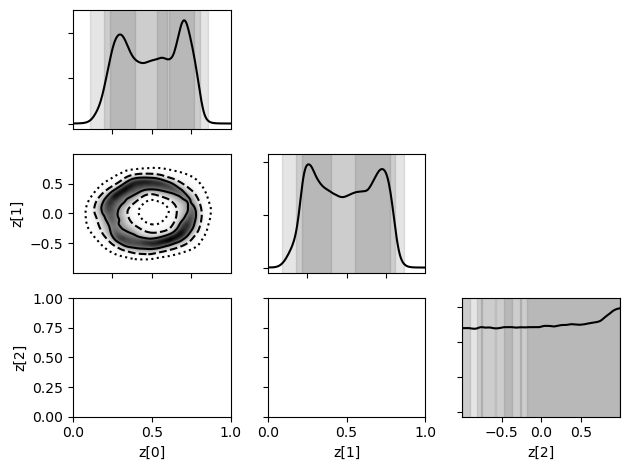

In [26]:
swyft.plot_corner(predictions, ['z[0]', 'z[1]', 'z[2]'], bins = 200, smooth = 3);

### Exercises


1. Extract information from `predictions`. What lenght is it? What types of `LogRatioSamples` does it contain? What is the shape of `logratios` and `params`?

In [27]:
# Results go here

2. Provide only partial information when making inference plot.

In [28]:
# Results go here

3. Extend above example to estimate all marginal posteriors.

In [13]:
# Results go here